### Implementation of AdaQN method on MNIST

#### Import Python libraries

In [1122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import *
import time
import random 
from numpy import linalg as LA
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix, precision_score, recall_score,f1_score
import copy
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


### MNIST dataset

In [1123]:
mnist = fetch_openml('mnist_784', version=1)
U0, v0 = mnist["data"], mnist["target"]
v = v0.astype(np.uint8) 
U= U0.astype(np.double) 

#### Change labels to {-1,+1} for binary classification 

In [1124]:
v_bin_5_lst = [2*int(v[i]==5)-1 for i in range(len(v))]

#### Create a single dataframe of the attributes and labels

In [1125]:
df_U = pd.DataFrame(data=U)
df_v = pd.DataFrame(data=np.asarray(v_bin_5_lst),  columns=['label'])
df_data_merged =pd.concat([df_U, df_v.reindex(df_U.index)], axis=1)
df_data_merged.head(10)


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1


In [1126]:
df_data_merged.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 785 entries, pixel1 to label
dtypes: float64(784), int32(1)
memory usage: 419.0 MB


#### Shuffle and split the data 

In [1127]:
def split_train_test(df_data_merged, train_set_size,test_set_size):
    #np.random.seed(0)
    shuffled_indices = np.random.permutation(len(df_data_merged))
    dic_train_set = {}
    dic_train_set_indices = shuffled_indices[:train_set_size]
    dic_train_set[0] = df_data_merged.iloc[dic_train_set_indices]
    dic_test_set= {}
    test_indices = shuffled_indices[-test_set_size:]
    dic_test_set[0] = df_data_merged.iloc[test_indices]
    return dic_train_set, dic_test_set


In [1128]:
dic_train_set_example,dic_test_set_example = split_train_test(df_data_merged,10000,1000)
npar_data= (dic_train_set_example[0]).to_numpy()
nparr_data_transp = npar_data.T
mnist_attr_data = nparr_data_transp[:-1,:]
mnist_labels =nparr_data_transp[-1:,:]

#### Define  objective function, gradient and Hessian

In [1129]:
def obj_function(x,df_data,mu_param):
    npar_data= (df_data).to_numpy()
    nparr_data_transp = npar_data.T
    data = nparr_data_transp[:-1,:]
    labels =nparr_data_transp[-1:,:]
    n_attributes,n_labels = np.shape(data)
    v1 = np.dot(data.T,x) 
    v2 = -np.multiply(labels.T,v1)
    obj_val = 0
    obj_val = sum([v2[i,0] if v2[i,0] > 709 else log(1+exp(v2[i,0])) for i in range(n_labels)])
    output = obj_val/n_labels + mu_param*np.dot(x.T,x)/(2)
    return output


In [1130]:
def gradient(x,df_data,eta):
    npar_data= (df_data).to_numpy()
    nparr_data_transp = npar_data.T
    data = nparr_data_transp[:-1,:]
    labels =nparr_data_transp[-1:,:]
    n_attributes,n_labels = np.shape(data)
    output = sum(-(labels[0,i]/(1+exp(min(709,labels[0,i]*np.dot(data[:,i],x)))))*data[:,[i]] 
                for i in range(n_labels))/n_labels
    return output+eta*x

In [1131]:
def Hessian(x,df_data,eta):
    npar_data= (df_data).to_numpy()
    nparr_data_transp = npar_data.T
    data = nparr_data_transp[:-1,:]
    labels =nparr_data_transp[-1:,:]
    n_attributes,n_labels = np.shape(data)
    output = np.zeros((n_attributes,1))
    output = sum(((labels[0,i])**2/(1+exp(min(709,labels[0,i]*np.dot(data[:,i],x))))**2)
                 *exp(min(709,labels[0,i]*np.dot(data[:,i],x)))*np.dot(data[:,[i]],data[:,[i]].T) 
                 for i in range(n_labels))/n_labels
    return output+eta*np.eye(n_attributes)

#### Solve  initial function and shape 

In [1132]:
def solve1(x,df_data,mu_param):
    npar_data= (df_data).to_numpy()
    nparr_data_transp = npar_data.T
    data = nparr_data_transp[:-1,:]
    labels =nparr_data_transp[-1:,:]
    n_attributes,n_labels = np.shape(data)
    output = np.zeros((n_attributes,2))
    return output

In [1133]:
def solve2(x,df_data,mu_param):
    npar_data= (df_data).to_numpy()
    nparr_data_transp = npar_data.T
    data = nparr_data_transp[:-1,:]
    labels =nparr_data_transp[-1:,:]
    n_attributes,n_labels = np.shape(data)
    return n_attributes

#### Enlarge the dataset

In [1134]:
def extension(dic_train_set,tn):
    first_tn_values = list(dic_train_set.values())[:tn]
    key_list = list(range(tn))
    value_list = first_tn_values 
    dict_from_list = dict(zip(key_list, value_list))
    return dict_from_list

#### Main algorithm when N=1000

In [1135]:
def ADAQN_format(dic_train_set,max_iter,epoch,stepsize,initial_x,memory_parameter,eta):
    obj_values = np.zeros(epoch+1)
    x_now = initial_x 
    x_next = initial_x 
    m = memory_parameter
    epoch_index = 0
    counter = 0
    s = solve1(x_now,dic_train_set[0],mu_param)
    y = solve1(x_now,dic_train_set[0],mu_param)
    tn = solve2(x_now,dic_train_set[0],mu_param)
    while tn < 1000:
        tn = min(2*tn, 1000)
        while counter < 3:
            counter += 1
            dic_train_set = extension(dic_train_set,tn)
            for k in range(max_iter+1):
                if k > 0:
                    s[:,0:m-1] = s[:,1:m]
                    s[:,[-1]] = x_next-x_now
                    y[:,0:m-1] = y[:,1:m]
                    y[:,[-1]] = gradient(x_next,dic_train_set[0],eta)-gradient(x_now,dic_train_set[0],eta)
                    x_now = x_next
                if k < m:
                    x_next = x_now - stepsize*gradient(x_now,dic_train_set[0],eta)
                else:
                    x_next = x_now - stepsize*two_loop_ADAQN_recursion(x_now,dic_train_set,s,y,m)
                if (k % ceil(max_iter/epoch)) == 0:
                    obj_values[epoch_index] = obj_function(x_now,dic_train_set[0],eta)
            epoch_index += 1
    return x_next, obj_values

In [1136]:
def two_loop_ADAQN_recursion(x,dic_train_set,s,y,m):
    g = gradient(x,dic_train_set[0],eta)
    rho = np.zeros((1,m))
    alpha = np.zeros((1,m))
    for i in range(m-1,-1,-1):
        rho[0,i] = 1 / np.dot(s[:,i],y[:,i])
        alpha[0,i] = rho[0,i]*np.dot(s[:,i],g)
        g = g - alpha[0,i]*y[:,[i]]
    r = (np.dot(s[:,-1],y[:,-1]) / np.dot(y[:,-1],y[:,-1]))*g
    for i in range(m):
        A = rho[0,i]*np.dot(y[:,i],r)
        r = r + s[:,[i]]*(alpha[0,i] - A)
    return r

#### Implentation

In [1137]:
train_set_size,test_set_size = 5000,1000
dic_train_set,dic_test_set = split_train_test(df_data_merged, train_set_size,test_set_size)
max_iter = 30
max_time = 6
n_attributes = len(dic_train_set[0].columns)-1
n_labels = len(dic_train_set[0])
epoch = 10
initial_x = np.zeros((n_attributes,1))
stepsize = .1
eta=10**(-2)
mu_param = 10**-2
dic_train_set_example,dic_test_set_example = split_train_test(df_data_merged,10000,1000)
results_ADAQN_1 = ADAQN_format(dic_train_set,max_iter,epoch,stepsize,initial_x,2,eta)
t3 = time.time()

obj_vals_ADAQN_1 = results_ADAQN_1[1]
print(obj_vals_ADAQN_1)

[4652.92661832  426.91883977  237.25162337    0.            0.
    0.            0.            0.            0.            0.
    0.        ]


#### Plot

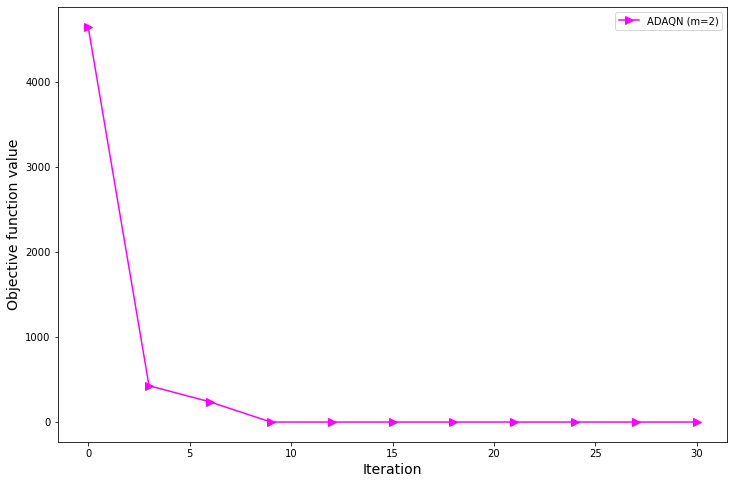

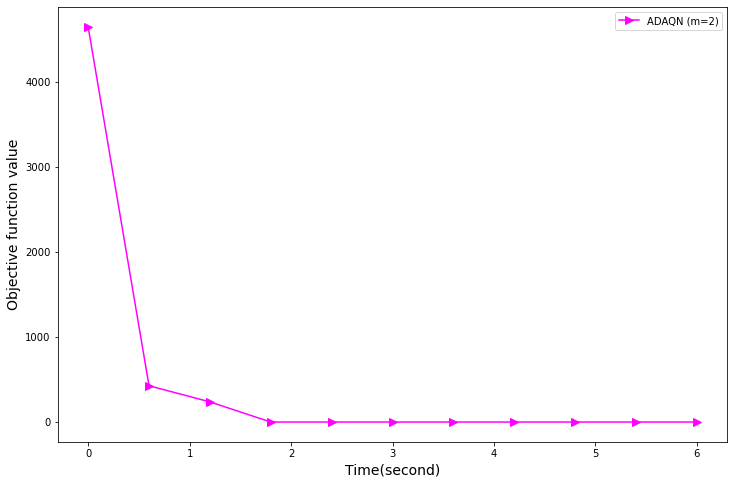

In [1139]:
fig = plt.figure(figsize=(12,8))

plt.plot(range(0,max_iter+1,ceil(max_iter/epoch)),obj_vals_ADAQN_1.tolist(),color='magenta',
         marker='>',markersize=8,linestyle='solid',label="ADAQN (m=2)")

plt.legend(loc="upper right")

plt.xlabel('Iteration',fontsize=14)
plt.ylabel('Objective function value',fontsize=14)
fig = plt.figure(figsize=(12,8))

plt.plot([i*max_time/epoch for i in range(len(obj_vals_ADAQN_1))],obj_vals_ADAQN_1.tolist(),color='magenta',marker='>',markersize=8,linestyle='solid',label="ADAQN (m=2)")


plt.legend(loc="upper right")

plt.xlabel('Time(second)',fontsize=14)
plt.ylabel('Objective function value',fontsize=14)

plt.show()
plt.show()
